In [22]:
%load_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
from pandas_ml_utils import pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


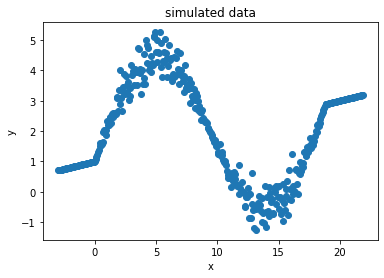

In [23]:
def create_sine_data(n = 300):
    np.random.seed(32)
    n = 300
    x = np.linspace(0, 1 * 2 * np.pi, n)
    y1 = 3 * np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1+np.random.normal(0, 0.15 * np.abs(y1), n), np.zeros(60)))
    x = np.concatenate((np.linspace(-3, 0, 60), np.linspace(0, 3 * 2 * np.pi, n),np.linspace( 3 * 2 * np.pi, 3 * 2 * np.pi + 3, 60)))
    y2 = 0.1*x+1
    y = y1+y2
    return x, y


## use custom function to simulate some data
x,y = create_sine_data(n=300) #A
plt.scatter(x=x,y=y,marker='o')
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
n=len(x)

In [28]:
df = pd.DataFrame(np.array(create_sine_data(300)).T, columns=["x", "y"])
with df.model() as m:
    from pandas_ml_utils import FeaturesAndLabels
    from pandas_ml_utils_torch import PytorchNN, PytorchModel
    from pandas_ml_utils_torch.loss import HeteroscedasticityLoss
    from pandas_ml_common.sampling.splitter import duplicate_data
    from torch.optim import Adam
    from torch import nn
    import torch as t

    class Net(PytorchNN):

        def __init__(self):
            super().__init__()
            self.l = nn.Sequential(
                nn.Linear(1, 20),
                nn.ReLU(),
                nn.Linear(20, 50),
                nn.ReLU(),
                nn.Linear(50, 20),
                nn.ReLU(),
                nn.Linear(20, 2),
            )

        def forward_training(self, x):
            return self.l(x)

        def forward_predict(self, x):
            x = self.l(x)
            # for sigma we use t.exp(sigma) to ensure non negative values, therefore we need to convert the value first
            x[:, 1] = t.exp(x[:, 1])
            return x

    fit = m.fit(
        PytorchModel(
            FeaturesAndLabels(
                ["x"],
                ["y"],
            ),
            Net,
            HeteroscedasticityLoss,
            Adam
        ),
        batch_size=32,
        fold_epochs=2000,
        splitter=duplicate_data()
    )

fit

sample weight has different dimensions torch.Size([32, 1]), torch.Size([32])


<AxesSubplot:>

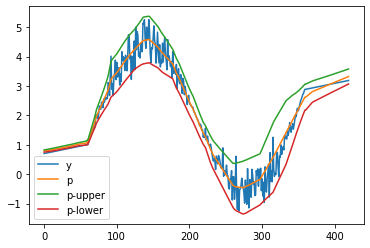

In [29]:
#fit.test_summary.df[["prediction", "label"]].plot()
fit.test_summary.df._[[
    "label",
    lambda df: df["prediction"].apply(lambda r: r[0][0], axis=1).rename("p"),
    lambda df: df["prediction"].apply(lambda r: r[0][0] + 2 * r[0][1], axis=1).rename("p-upper"),
    lambda df: df["prediction"].apply(lambda r: r[0][0] - 2 * r[0][1], axis=1).rename("p-lower"),
]].plot()